# Non-linear models

Author: Evelyn Fitzgerald

We decided to use a ResNet-18 neural network modified to do regression &ndash; output a real-valued scalar score indicating the level of blight in a picture. A neural network can be thought of as having two components:

- a feature extractor, which transforms the input data (which is high-dimensional) into a lower-dimensional feature space that is suitable for the task at hand; and
- a "head" that transforms the feature vectors into output values (such as class probabilities for classification or scores for regression).

In our model, the head is an `nn.Linear` layer that transforms the feature vectors of size 512 into scalars using the formula $y = w \cdot x + b$, where $w$ and $b$ are learned parameters. In this notebook, I tried modifying the head of the neural network in two ways:

- fine-tuning it, i.e. freezing the other parts of the neural network so that only the weights of the head would be updated during training; and
- replacing it with a layer that does a quadratic transformation on the feature vectors (e.g. $y = x^T A x + B x + C$) instead of a linear one.

At its simplest, a quadratic layer can be created by combining an `nn.Bilinear` layer (which does the $x^T A x$ part) and an `nn.Linear` layer (which does the $B x + C$ part). However, it tends to produce outliers that are far outside the normal output range. Our neural network predicts [TrueSkill scores](https://en.wikipedia.org/wiki/TrueSkill), which must be in the range [0, 50]. So I had to explicitly constrain the output to be in this range, which I did by passing the quadratic outputs through a scaled sigmoid function: $y = \sigma(z / 50) \cdot 50$. The standard logistic function $\sigma(\cdot)$ compresses the entire real line into the interval [0, 1], so the output must be scaled by a factor of 50 to span the interval [0, 50]. The input is also scaled down to avoid the vanishing gradient problem: since most of the TrueSkill scores are near 25, the center of the range of valid TrueSkill scores, we want to scale the quadratic outputs so that most of the values are near 0.5, where the gradient of the sigmoid is highest. If we applied the sigmoid without scaling the scores down first, most of the gradients would be very small.

## Summary of results

- Original model: R<sup>2</sup> = 0.306
- Fine-tuned linear model: R<sup>2</sup> = 0.298
- Quadratic model: R<sup>2</sup> = 0.259

Using the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) as our main metric, the quadratic model performed worse than either the fine-tuned linear model or the original model. Having many more parameters than the linear models, the quadratic model may have overfit the training set.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm, trange

import numpy as np
import statistics
from copy import deepcopy
from scipy.stats import norm, linregress

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
from sklearn.manifold import TSNE

import train
from data import get_loader, ImageDataset

In [2]:
# Mock CLI args
args = {
    'pretrain': False,
    'label_type': 'regr', # requires PR #2: https://github.com/Changing-Cities-Research-Lab/gsv-ml-buildings-new/pull/2
    'batch_size': 16,
    'lr': 3e-5, # set larger learning rate because we're not fine-tuning the NN (or just try 1e-5)
    'l2': 3e-4,
    'gpu': True,
    'weighted': True,
    'upsample': False,
    'add_bos': False,
    'data_path': '../../gsv-ml-buildings-new', # Use main gsv directory instead of os.chdir
    'time_series': False
}

In [3]:
!ls ../../tingyan.deng/gsv-ml-buildings-new-2-inception/exps/resnet18/checkpoints

0_133922.pth   15_960381.pth  20_989647.pth  2_487032.pth   7_770044.pth
10_864810.pth  16_971441.pth  21_991812.pth  31_993272.pth  8_810045.pth
11_892440.pth  17_976384.pth  22_992418.pth  3_555932.pth   9_829612.pth
12_916021.pth  18_984471.pth  24_992476.pth  4_621032.pth
13_936272.pth  19_989011.pth  25_993089.pth  5_684790.pth
14_947992.pth  1_355770.pth   26_993196.pth  6_722782.pth


In [4]:
model = models.resnet18(pretrained=False)
state_dict = torch.load('../../tingyan.deng/gsv-ml-buildings-new-2-inception/exps/resnet18/checkpoints/31_993272.pth')
model.fc = nn.Linear(512, 1, True)
model.load_state_dict(state_dict)
model = model.eval().cuda()

In [5]:
train_boston = ImageDataset([f"{args['data_path']}/datasets/boston/"], 'train', 'regr')
val_boston = ImageDataset([f"{args['data_path']}/datasets/boston/"], 'val', 'regr')
train_detroit = ImageDataset([f"{args['data_path']}/datasets/detroit/"], 'train', 'regr')
val_detroit = ImageDataset([f"{args['data_path']}/datasets/detroit/"], 'val', 'regr')

In [6]:
def make_loader(dataset):
    return DataLoader(dataset, batch_size=args['batch_size'], shuffle=False, num_workers=0, sampler=None)

In [7]:
train_loader_boston = make_loader(train_boston)
val_loader_boston = make_loader(val_boston)
train_loader_detroit = make_loader(train_detroit)
val_loader_detroit = make_loader(val_detroit)

In [8]:
len(val_boston), len(val_detroit)

(741, 1000)

## Trying out different regression models
- Original
- Trained linear
- Trained quadratic


In [9]:
def get_outputs(model, val_loader):
    model.eval()
    outputs_list = []
    for imgs, scores in tqdm(val_loader, desc='Eval model'):
        imgs = imgs.cuda()
        outputs = model(imgs).cpu().detach().numpy()
        outputs_list.append(outputs)
    return np.concatenate(outputs_list)

def get_pred_scores(model, val_loader):
    '''Get a NumPy array of all the scores predicted by the model on the dataset.'''
    all_pred_scores = get_outputs(model, val_loader)
    return all_pred_scores.squeeze(axis=1)

In [10]:
def plot_line(slope, intercept, color, label):
    """Plot a line from slope and intercept
    plt.axline not available in this version, so use this instead
    From https://stackoverflow.com/a/43811762"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-' + color, label=label)

def plot_linreg(scores, pred_scores, linreg_obj, title):
    plt.title(title)
    plt.scatter(scores, pred_scores)
    plot_line(linreg_obj.slope, linreg_obj.intercept, 'r', f'Fitted line (R**2 = {linreg_obj.rvalue**2:.3f})')
    plot_line(1, 0, 'm', 'Ideal line')
    plt.xlabel('Actual scores')
    plt.ylabel('Predicted scores')
    plt.legend()

### Original linear model

In [11]:
scores_detroit = val_detroit.csv.score.to_numpy()

In [12]:
pred_scores_detroit = get_pred_scores(model, val_loader_detroit)

Eval model:   0%|          | 0/63 [00:00<?, ?it/s]

In [13]:
linreg_detroit = linregress(scores_detroit, pred_scores_detroit)

In [14]:
linreg_detroit

LinregressResult(slope=0.35780950566636754, intercept=15.987287773725727, rvalue=0.5527595312756984, pvalue=4.362663918418054e-81, stderr=0.01707548359911857)

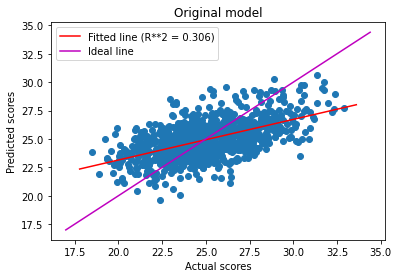

In [15]:
%matplotlib inline
plot_linreg(scores_detroit, pred_scores_detroit, linreg_detroit, 'Original model')

### Trained linear model

In [16]:
def prepare_model(model, new_head=None):
    model_copy = deepcopy(model)
    if new_head:
        model_copy.fc = new_head
    # Freeze everything except the head
    model_copy.requires_grad_(False)
    model_copy.fc.requires_grad_(True)
    return model_copy

In [17]:
model_linear = prepare_model(model)

In [18]:
optimizer_linear = optim.Adam(model_linear.parameters(), lr=args['lr'], weight_decay=args['l2'])

In [19]:
for i in trange(5):
    train.train(model_linear, train_loader_detroit, optimizer_linear, args, i)
    train.eval(model_linear, val_loader_detroit, args, i)

  0%|          | 0/5 [00:00<?, ?it/s]

train 1:   0%|          | 0/250 [00:00<?, ?it/s]

train 1
Loss	3.303


eval 1:   0%|          | 0/63 [00:00<?, ?it/s]

eval 1
Loss	4.327


train 2:   0%|          | 0/250 [00:00<?, ?it/s]

train 2
Loss	3.322


eval 2:   0%|          | 0/63 [00:00<?, ?it/s]

eval 2
Loss	4.297


train 3:   0%|          | 0/250 [00:00<?, ?it/s]

train 3
Loss	3.415


eval 3:   0%|          | 0/63 [00:00<?, ?it/s]

eval 3
Loss	4.337


train 4:   0%|          | 0/250 [00:00<?, ?it/s]

train 4
Loss	3.370


eval 4:   0%|          | 0/63 [00:00<?, ?it/s]

eval 4
Loss	4.333


train 5:   0%|          | 0/250 [00:00<?, ?it/s]

train 5
Loss	3.384


eval 5:   0%|          | 0/63 [00:00<?, ?it/s]

eval 5
Loss	4.374


In [20]:
pred_scores_linear = get_pred_scores(model_linear, val_loader_detroit)

Eval model:   0%|          | 0/63 [00:00<?, ?it/s]

In [21]:
linreg_linear_trained = linregress(scores_detroit, pred_scores_linear)

In [22]:
linreg_linear_trained

LinregressResult(slope=0.3554117809627549, intercept=15.836896826280887, rvalue=0.5458029807194766, pvalue=1.0399780234937795e-78, stderr=0.01727149200030284)

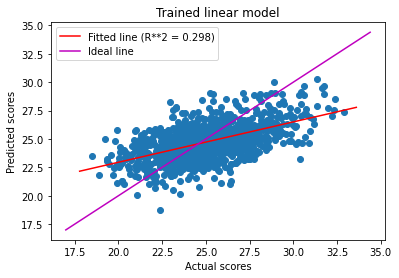

In [23]:
plot_linreg(scores_detroit, pred_scores_linear, linreg_linear_trained, 'Trained linear model')

### Quadratic model

In [24]:
class Quadratic(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Quadratic, self).__init__()
        self.quad = nn.Bilinear(in_features, in_features, out_features, bias=False)
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x^T*A*x + B*x + C
        axx = self.quad(x, x)
        bxc = self.linear(x)
        z = axx + bxc
        # Apply sigmoid and scale by 50
        return self.sigmoid(z / 50) * 50

In [25]:
model_quadratic = prepare_model(model, new_head=Quadratic(512, 1)).cuda()

In [26]:
optimizer_quadratic = optim.Adam(model_quadratic.parameters(), lr=args['lr'], weight_decay=args['l2'])

In [27]:
for i in trange(15):
    train.train(model_quadratic, train_loader_detroit, optimizer_quadratic, args, i)
    train.eval(model_quadratic, val_loader_detroit, args, i)

  0%|          | 0/15 [00:00<?, ?it/s]

train 1:   0%|          | 0/250 [00:00<?, ?it/s]

train 1
Loss	5.777


eval 1:   0%|          | 0/63 [00:00<?, ?it/s]

eval 1
Loss	7.216


train 2:   0%|          | 0/250 [00:00<?, ?it/s]

train 2
Loss	4.895


eval 2:   0%|          | 0/63 [00:00<?, ?it/s]

eval 2
Loss	7.353


train 3:   0%|          | 0/250 [00:00<?, ?it/s]

train 3
Loss	4.732


eval 3:   0%|          | 0/63 [00:00<?, ?it/s]

eval 3
Loss	4.958


train 4:   0%|          | 0/250 [00:00<?, ?it/s]

train 4
Loss	4.419


eval 4:   0%|          | 0/63 [00:00<?, ?it/s]

eval 4
Loss	5.537


train 5:   0%|          | 0/250 [00:00<?, ?it/s]

train 5
Loss	4.400


eval 5:   0%|          | 0/63 [00:00<?, ?it/s]

eval 5
Loss	4.613


train 6:   0%|          | 0/250 [00:00<?, ?it/s]

train 6
Loss	4.401


eval 6:   0%|          | 0/63 [00:00<?, ?it/s]

eval 6
Loss	5.355


train 7:   0%|          | 0/250 [00:00<?, ?it/s]

train 7
Loss	4.242


eval 7:   0%|          | 0/63 [00:00<?, ?it/s]

eval 7
Loss	7.885


train 8:   0%|          | 0/250 [00:00<?, ?it/s]

train 8
Loss	4.144


eval 8:   0%|          | 0/63 [00:00<?, ?it/s]

eval 8
Loss	6.663


train 9:   0%|          | 0/250 [00:00<?, ?it/s]

train 9
Loss	4.159


eval 9:   0%|          | 0/63 [00:00<?, ?it/s]

eval 9
Loss	4.526


train 10:   0%|          | 0/250 [00:00<?, ?it/s]

train 10
Loss	4.042


eval 10:   0%|          | 0/63 [00:00<?, ?it/s]

eval 10
Loss	5.267


train 11:   0%|          | 0/250 [00:00<?, ?it/s]

train 11
Loss	4.098


eval 11:   0%|          | 0/63 [00:00<?, ?it/s]

eval 11
Loss	5.264


train 12:   0%|          | 0/250 [00:00<?, ?it/s]

train 12
Loss	4.163


eval 12:   0%|          | 0/63 [00:00<?, ?it/s]

eval 12
Loss	5.096


train 13:   0%|          | 0/250 [00:00<?, ?it/s]

train 13
Loss	3.976


eval 13:   0%|          | 0/63 [00:00<?, ?it/s]

eval 13
Loss	4.702


train 14:   0%|          | 0/250 [00:00<?, ?it/s]

train 14
Loss	4.166


eval 14:   0%|          | 0/63 [00:00<?, ?it/s]

eval 14
Loss	5.058


train 15:   0%|          | 0/250 [00:00<?, ?it/s]

train 15
Loss	3.979


eval 15:   0%|          | 0/63 [00:00<?, ?it/s]

eval 15
Loss	4.602


In [28]:
pred_scores_quadratic = get_pred_scores(model_quadratic, val_loader_detroit)

Eval model:   0%|          | 0/63 [00:00<?, ?it/s]

In [29]:
linreg_quadratic = linregress(scores_detroit, pred_scores_quadratic)

In [30]:
linreg_quadratic

LinregressResult(slope=0.3260245193531057, intercept=16.66067147992758, rvalue=0.5089406504212509, pvalue=5.3410965930144675e-67, stderr=0.017455043020649503)

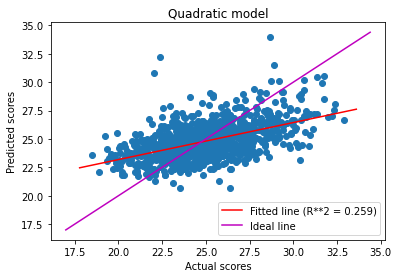

In [31]:
plot_linreg(scores_detroit, pred_scores_quadratic, linreg_quadratic, 'Quadratic model')